# Titanic Data Visualization

Basics Python Visualization Homework

<br> Name : Andi Buwono
<br> NIK : 83051

## Load Libraries and Read Data

In [1]:
### Load Libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
from plotnine import *


# enable inline plot
%matplotlib inline

# set default theme plot
mpl.style.use('ggplot')

Data used are Kaggle [Titanic](https://www.kaggle.com/c/3136/download-all) data. Download (login needed) and extract to *data* folder. Below are descriptions of the parameter in the dataset.

| Variable | Definition | Key |
| :- | :- | :- |
| Survival | Survival| 0 = No, 1 = Yes |
| Pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Sex | Sex | |
| Age | Age in years | |
| Sibsp | # of siblings / spouses aboard the Titanic | |
| Parch | # of parents / children aboard the Titanic | |
| Ticket | Ticket number | |
| Fare | Passenger fare | |
| cabin | Cabin number | |
| Embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

In [2]:
### Read data from kaggle
titanic_df = pd.read_csv('data/train.csv')

## EDA

In [3]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


Based on **Name** uniqueness, limited understanding on **Ticket** numbering and many missing value on **Cabin** number, then we do not include those parameters in the data visualization.

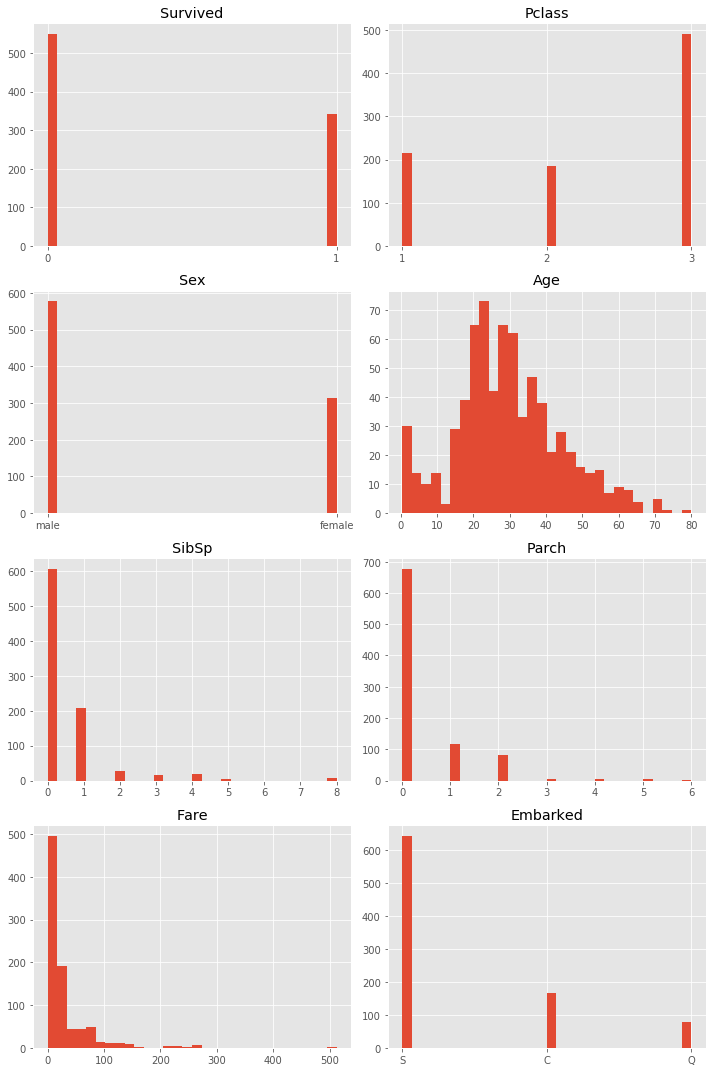

In [5]:
# select column included in hsitogram
eda_df = titanic_df.drop(columns=['Name', 'Ticket', 'Cabin']).set_index('PassengerId')

# print all histogram
n_col = 2

fig, ax = plt.subplots(nrows=eda_df.shape[1] // n_col + (eda_df.shape[1] % n_col > 0),
                       ncols=n_col, figsize=[10, 15])
ax = ax.flatten()

axi = 0
for label, content in eda_df.items():

    # show histogram
    ax[axi].hist(content.dropna(), bins = 30)

    # show as categorial for unique less than 4
    if content.nunique() < 4:
        ax[axi].set_xticks(content.dropna().unique())

    # add title
    ax[axi].set_title(label)

    axi +=1


plt.tight_layout()

based on histogram above, binning are done in these parameters:


| Variable | Bins | 
| :- | :- |
| Age | 0-16, 16-50, >50 | |
| Sibsp | 0, 1, >2 | |
| Parch | 0, 1, >2 | |
| Fare | 0-25, 25-50, >50 | |


## Data Summaries

Bin **Age**, **SibSp**, **Parch** and **Fare**

In [6]:
# binning labels, these also used for sorting the bins in the visualization
age_label = ['0-16', '16-50', '>50']
sibsp_label = ['0', '1', u'\u22652']
parch_label = ['0', '1',  u'\u22652']
fare_label = ['0-25','25-50', '>50']


# bin according to bins above
titanic_df['Age_Binned'] = pd.cut(titanic_df['Age'],
                                  bins=[0, 16, 50, 200],
                                  labels=age_label,
                                  include_lowest=True)

titanic_df['SibSp_Binned'] = pd.cut(titanic_df['SibSp'],
                                    bins=[0, 1, 2, 10],
                                    labels=sibsp_label,
                                    include_lowest=True)

titanic_df['Parch_Binned'] = pd.cut(titanic_df['Parch'],
                                    bins=[0, 1, 2, 10],
                                    labels=parch_label,
                                    include_lowest=True)

titanic_df['Fare_Binned'] = pd.cut(titanic_df['Fare'],
                                  bins=[0, 25, 50, 1000],
                                  labels=fare_label,
                                  include_lowest=True)
# fill ticket class
titanic_df['Pclass'] = titanic_df['Pclass'].replace({1: '1st', 2: '2nd', 3: '3rd'})


Melt, Group and Summaries by *Pclass*, *Sex*, *Age_Binned*, *SibSp_Binned*, *Parch_Binned*, *Fare_Binned* for **Survived Number** and **Survival Rate**

In [7]:
# function to count and calculate survival rate
def survival_rate(df):
    # number of survived passanger in segment
    survived_num = df['Survived'].sum()
    # number of not survived passanger in segment
    not_survived_num =  df['Survived'].count() - survived_num
    # ratio of survived passanger to all passenger in segment
    survival_rate = survived_num / df['Survived'].count()
    return pd.Series({'Survived': survived_num,
                      'Not_Survived': not_survived_num,
                      'Survival_Rate': survival_rate})


# function to calculate portion of to total
def portion_to_total(df):
    # portion survived in segment compared to all passenger
    df['Portion_to_Survived'] = df['Survived'] / df['Survived'].sum()
    # portion passenger in segment compared to all passenger
    df['Portion_to_All'] =  (df['Survived'] + df['Not_Survived']) / (df['Survived'] + df['Not_Survived']).sum()
    # ratio of segment survival rate to other segment survival rate
    df['Survival_Affinity'] = df['Survival_Rate'] / ((df['Survived'].sum() - df['Survived']) / ((df['Survived'] + df['Not_Survived']).sum() - (df['Survived'] + df['Not_Survived'])))
    df['Best_in_Segment'] = df['Survival_Rate'] ==  df['Survival_Rate'].max()
    return df


## parameter independent summary
titanic_summarized = titanic_df.\
    melt(id_vars=['PassengerId','Survived'],
         value_vars=['Pclass', 'Sex', 'Age_Binned',
                     'SibSp_Binned', 'Parch_Binned', 'Fare_Binned', 'Embarked'],
         var_name='Parameter',
         value_name='Category').\
    groupby(by=['Parameter', 'Category']).\
    apply(survival_rate).\
    groupby(by=['Parameter']).\
    apply(portion_to_total).\
    reset_index()

titanic_summarized


,Parameter,Category,Survived,Not_Survived,Survival_Rate,Portion_to_Survived,Portion_to_All,Survival_Affinity,Best_in_Segment
0,Age_Binned,0-16,55.0,45.0,0.550000,0.189655,0.140056,1.437021,True
1,Age_Binned,16-50,213.0,337.0,0.387273,0.734483,0.770308,0.824841,False
2,Age_Binned,>50,22.0,42.0,0.343750,0.075862,0.089636,0.833722,False
3,Embarked,C,93.0,75.0,0.553571,0.273529,0.188976,1.615891,True
4,Embarked,Q,30.0,47.0,0.389610,0.088235,0.086614,1.020528,False
5,Embarked,S,217.0,427.0,0.336957,0.638235,0.724409,0.671174,False
6,Fare_Binned,0-25,160.0,397.0,0.287253,0.467836,0.625140,0.527157,False
7,Fare_Binned,25-50,73.0,101.0,0.419540,0.213450,0.195286,1.118254,False
8,Fare_Binned,>50,109.0,51.0,0.681250,0.318713,0.179574,2.137312,True
9,Parch_Binned,0,298.0,498.0,0.374372,0.871345,0.893378,0.808303,False


## Visualization

In [8]:
# Color Palette
# Based on https://www.ebay.co.uk/itm/273934485281
color_blue = "#004B80"
color_blue_light ="#38769E"
color_white = "#FFFFFF"

# Picture size in inch
fig_height = 12
fig_width = 9


# inch to figure ratio converter helper class
class convert():
    def height(self, unit):
        return unit/fig_height
    def width(self, unit):
        return unit/fig_width


cv = convert()

### Survival Rate Graph

In [9]:
# prepare visualization data
# sort segment
display_df = titanic_summarized.loc[[20,15,16,21,0,1,2,22,12,13,14,23,3,4,5,24,6,7,8,25,9,10,11,26,17,18,19 ],:].\
    reset_index(drop=True).\
    reset_index()

# parameter name
param_df = pd.DataFrame({'Parameter': ['Sex', 'Age_Binned', 'Pclass', 'Embarked', 'Fare_Binned',
                                       'Parch_Binned', 'SibSp_Binned'],
                         'Group': ['Sex', 'Age (year)', 'Passenger Class', 'City Embarked',
                                   u'Ticket Fare (\u00A3)', 'Parents or Children aboard (number)',
                                   'Siblings or spouses aboard (number)'],
                         'Affinity_Comment': ['for female\nthan male', 'for children\nthan adult', 'for $1^{st}$ class\nthan other class',
                                              'for Cherboug\nembarkation\nthan other city',
                                              u'for ficket\nfare greater\nthan \u00A350',
                                              'for passenger\nwith\none parent\nthan other',
                                              'for passenger\nwith\none sibling\nthan other']})

# title case sex and fill city embarkation name
display_df['Category'] = display_df['Category'].replace({'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton',
                                                         'female': 'Female', 'male': 'Male',
                                                         '1st': '$1^{st}$', '2nd': '$2^{nd}$',  '3rd': '$3^{rd}$' })

# apply displayed parameter name
display_df = display_df.merge(param_df, how='left', on='Parameter')
display_df = display_df.merge(display_df.groupby('Parameter')['index'].median().reset_index(name='affinity_y'),
                              how='left', on='Parameter')



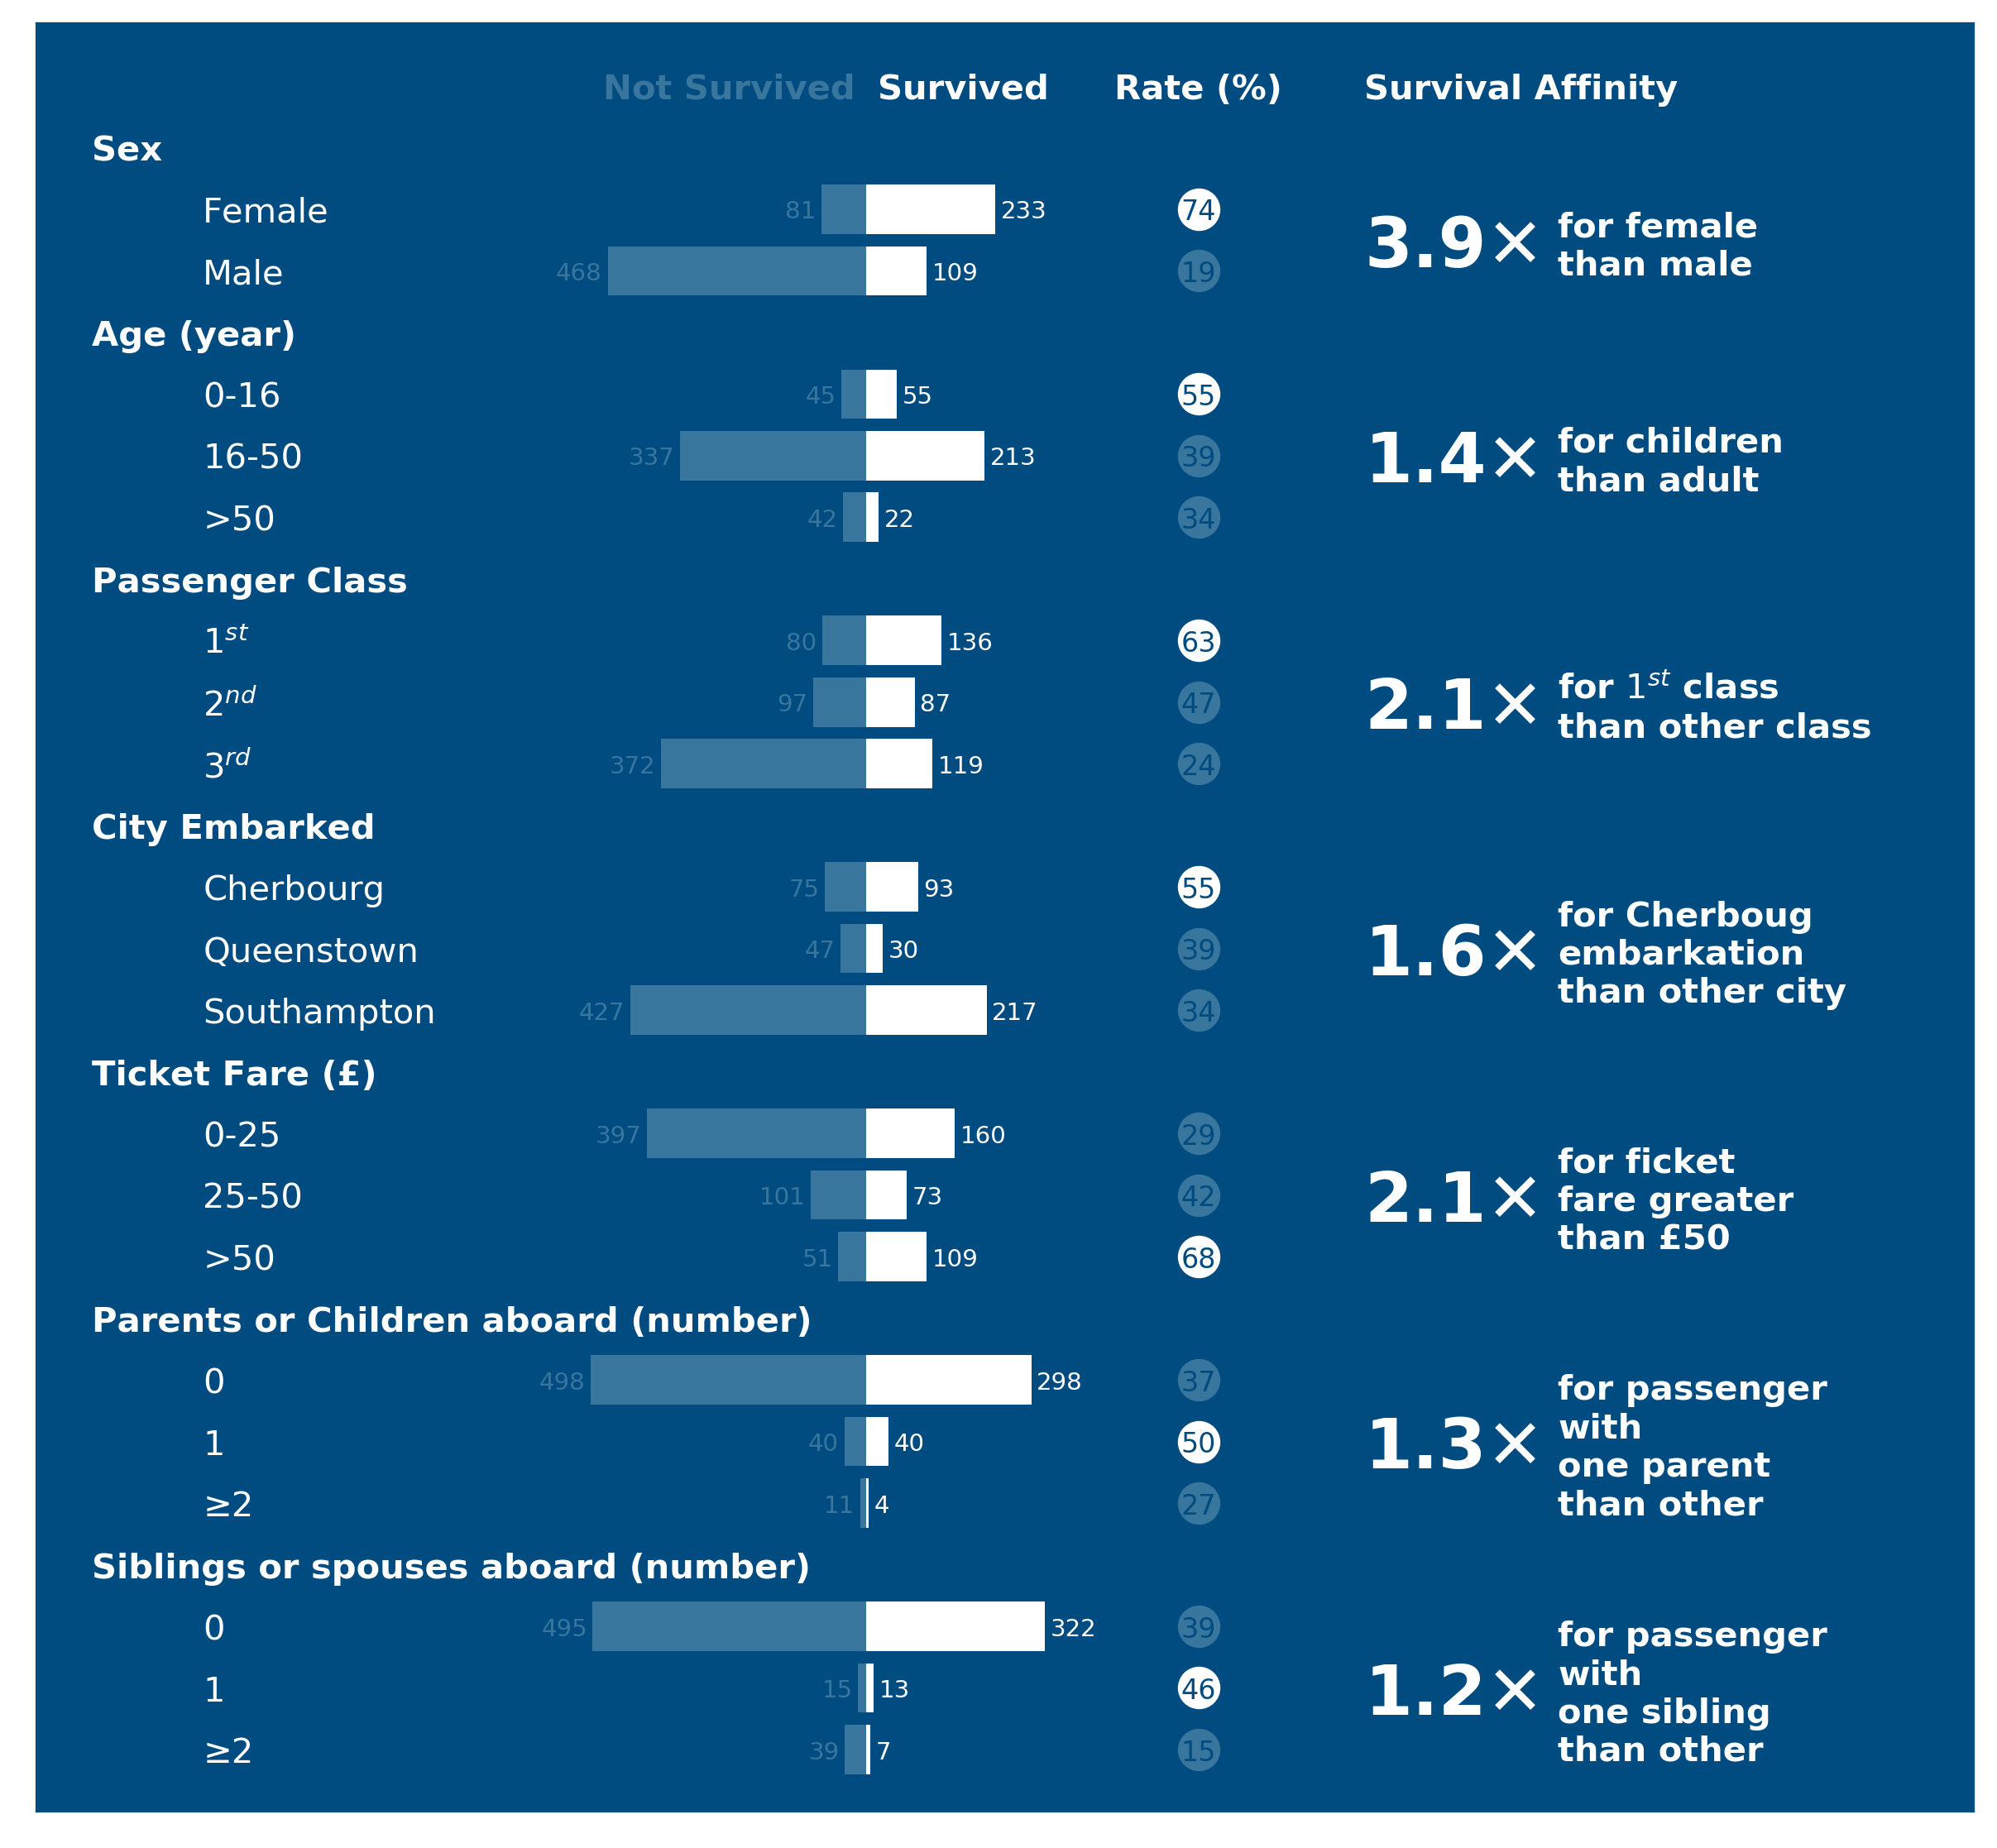

In [10]:
fig = plt.Figure(figsize=[fig_width, fig_height], dpi=300)

# prepared axes
ax =  fig.add_axes([cv.width(0.8), cv.height(1.8), cv.width(fig_width-1.2),
                    cv.height(fig_height-4.8)],
                    facecolor=color_blue)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlim(-1500, 2000)
ax.set_ylim(-27,2)
plt.setp(ax.spines.values(), color=color_blue);

# survived and not survived legend
ax.text(20, 1, "Survived",
         color=color_white, va='center_baseline', fontweight='bold')
ax.text(600, 1, "Rate (%)",
         color=color_white, va='center_baseline', fontweight='bold', ha='center')
ax.text(-20, 1, "Not Survived",
         color=color_blue_light, va='center_baseline', fontweight='bold', ha='right')
ax.text(900, 1, "Survival Affinity",
         color=color_white, va='center_baseline', fontweight='bold',)

# number of survived per segment barplot and number label
ax.barh(-display_df['index'], width=display_df['Survived'],
        fc=color_white)
[ax.text(row['Survived'] + 10, -row['index'], "{:0.0f}".format(row['Survived']),
         color=color_white, va='center_baseline', size=7)
     for _,row in display_df.dropna().iterrows()]
# number of not survived per segment barplot and number label
ax.barh(-display_df['index'], width=-display_df['Not_Survived'],
        fc=color_blue_light)
[ax.text(-row['Not_Survived'] - 10, -row['index'], "{:0.0f}".format(row['Not_Survived']),
         color=color_blue_light, va='center_baseline', ha='right', size=7)
     for _,row in display_df.dropna().iterrows()]

# segment labels
[ax.text(-1200, -row['index'], "{}".format(row['Category']),
         color=color_white, va='center_baseline')
    for _,row in display_df.dropna().iterrows()]

# segment group label
[ax.text(-1400, -row['index']+1, "{}".format(row['Group']),
         color=color_white, va='center_baseline', fontweight='bold')
    for _,row in display_df.dropna().loc[:,['index','Group']].drop_duplicates(subset='Group').iterrows()]

# rate per segments
[ax.scatter(600, -row['index'], c=color_white, s=140)
    for _,row in display_df.loc[display_df['Best_in_Segment'] == True, :].iterrows()]
[ax.text(600, -row['index'], "{:0.0f}".format(row['Survival_Rate'] * 100.0),
         color=color_blue, va='center_baseline', size=8, ha='center')
     for _,row in display_df.loc[display_df['Best_in_Segment']  == True, :].iterrows()]

[ax.scatter(600, -row['index'], c=color_blue_light, s=140)
    for _,row in display_df.loc[display_df['Best_in_Segment'] == False, :].iterrows()]
[ax.text(600, -row['index'], "{:0.0f}".format(row['Survival_Rate'] * 100.0),
         color=color_blue, va='center_baseline', size=8, ha='center')
     for _,row in display_df.loc[display_df['Best_in_Segment']  == False, :].iterrows()]


# affinity best survivor segment
[ax.text(900, -row['affinity_y'], u"{:0.1f}\u2715".format(row['Survival_Affinity'] ),
         color=color_white, va='center_baseline', size=20, ha='left', fontweight='bold')
     for _,row in display_df.loc[display_df['Best_in_Segment']  == True, :].iterrows()]

[ax.text(1250, -row['affinity_y'], row['Affinity_Comment'],
         color=color_white, va='center_baseline', size=10, ha='left', fontweight='bold')
     for _,row in display_df.loc[display_df['Best_in_Segment']  == True, :].iterrows()]

# preview
fig


### Keeping it together

In [11]:
# create figure
fig_vis = plt.Figure(figsize=[fig_width, fig_height], dpi=300)

# create background shapes
ax_background = fig_vis.add_axes([0.0, 0., 1.0, 1.0], facecolor=color_white)
ax_background.get_xaxis().set_visible(False)
ax_background.get_yaxis().set_visible(False)
plt.setp(ax_background.spines.values(), color=color_white);

ax_panel = fig_vis.add_axes([cv.width(0.4), cv.height(1.0), cv.width(fig_width-0.8), cv.height(fig_height-1.4)],
                        facecolor=color_blue)

ax_panel.get_xaxis().set_visible(False)
ax_panel.get_yaxis().set_visible(False)
ax_panel.set_xlim(0.0, 1.0)
ax_panel.set_ylim(0.0, 1.0)
plt.setp(ax_panel.spines.values(), color=color_blue);


In [12]:
# iceberg and ships polygons and title
iceberg_coords = np.array([[0,0],
                          [0.141935483870969,0.213793103448276],
                          [0.200000000000002,0.220689655172413],
                          [0.26451612903226,0.337931034482758],
                          [0.35483870967742,0.4],
                          [0.651612903225808,0.331034482758621],
                          [0.741935483870968,0.248275862068964],
                          [0.858064516129034,0.199999999999999],
                          [1,0]])

ship_coords = np.array([[0.641447436258785,0],
                        [0,0.679481049067325],
                        [0.140722205800477,0.66346590288482],
                        [0.119240260945476,0.769659089529971],
                        [0.162204150655458,0.8],
                        [0.441469433770303,0.55727271623967],
                        [0.419987488915325,0.481420440064564],
                        [0.548879158045248,0.390397708654445],
                        [1,0.66346590288482],
                        [0.61332499261021,0.344886342949385],
                        [0.806662496305115,0.223522701069203],
                        [0.806662496305115,0.178011335364144],
                        [0.849626386015097,0.147670424894098],
                        [1.021481944855,0.253863611539249],
                        [1.10740972427494,0.208352245834189],
                        [0.957036110290018,0.102159059189038],
                        [1.021481944855,0] ])

iceberg =  Polygon(iceberg_coords/4 + np.array([0.35, 0.8]), True,
                   fc='white')


ship =  Polygon(ship_coords/24 + np.array([0.52, 0.8]), True,
                   fc=color_blue)

ax_panel.add_patch(iceberg)
ax_panel.add_patch(ship)

ax_panel.annotate("Who survived the TITANIC?", xy=(0.5, 0.78), xycoords="axes fraction",
                  ha='center', va='top', color=color_white, fontsize=25, fontweight='semibold');

In [13]:
# foot note and disclaimer
ax_background.annotate("Andi Buwono", xy=(cv.width(1.5),cv.height(0.8)), xycoords="figure fraction",
                       ha='center', va='top', color=color_blue, fontsize=17);

ax_background.annotate("83051", xy=(cv.width(1.5),cv.height(0.3)), xycoords="figure fraction",
                       ha='center', va='bottom', color=color_blue, fontsize=17);

ax_background.annotate("rate is a ratio of number survived to all passenger in segment",
                       xy=(cv.width(3),cv.height(0.8)), xycoords="figure fraction",
                       ha='left', va='top', color=color_blue, fontsize=8.5);

ax_background.annotate("affinity is a ratio of survival rate to other segments combined survival rate in segment group",
                       xy=(cv.width(3),cv.height(0.69)), xycoords="figure fraction",
                       ha='left', va='top', color=color_blue, fontsize=8.5);

ax_background.annotate("dataset from https://www.kaggle.com/c/3136/download-all",
                       xy=(cv.width(3),cv.height(0.58)), xycoords="figure fraction",
                       ha='left', va='top', color=color_blue, fontsize=8.5);

ax_background.annotate("artwork based on https://www.ebay.co.uk/itm/273934485281",
                       xy=(cv.width(3),cv.height(0.47)), xycoords="figure fraction",
                       ha='left', va='top', color=color_blue, fontsize=8.5);

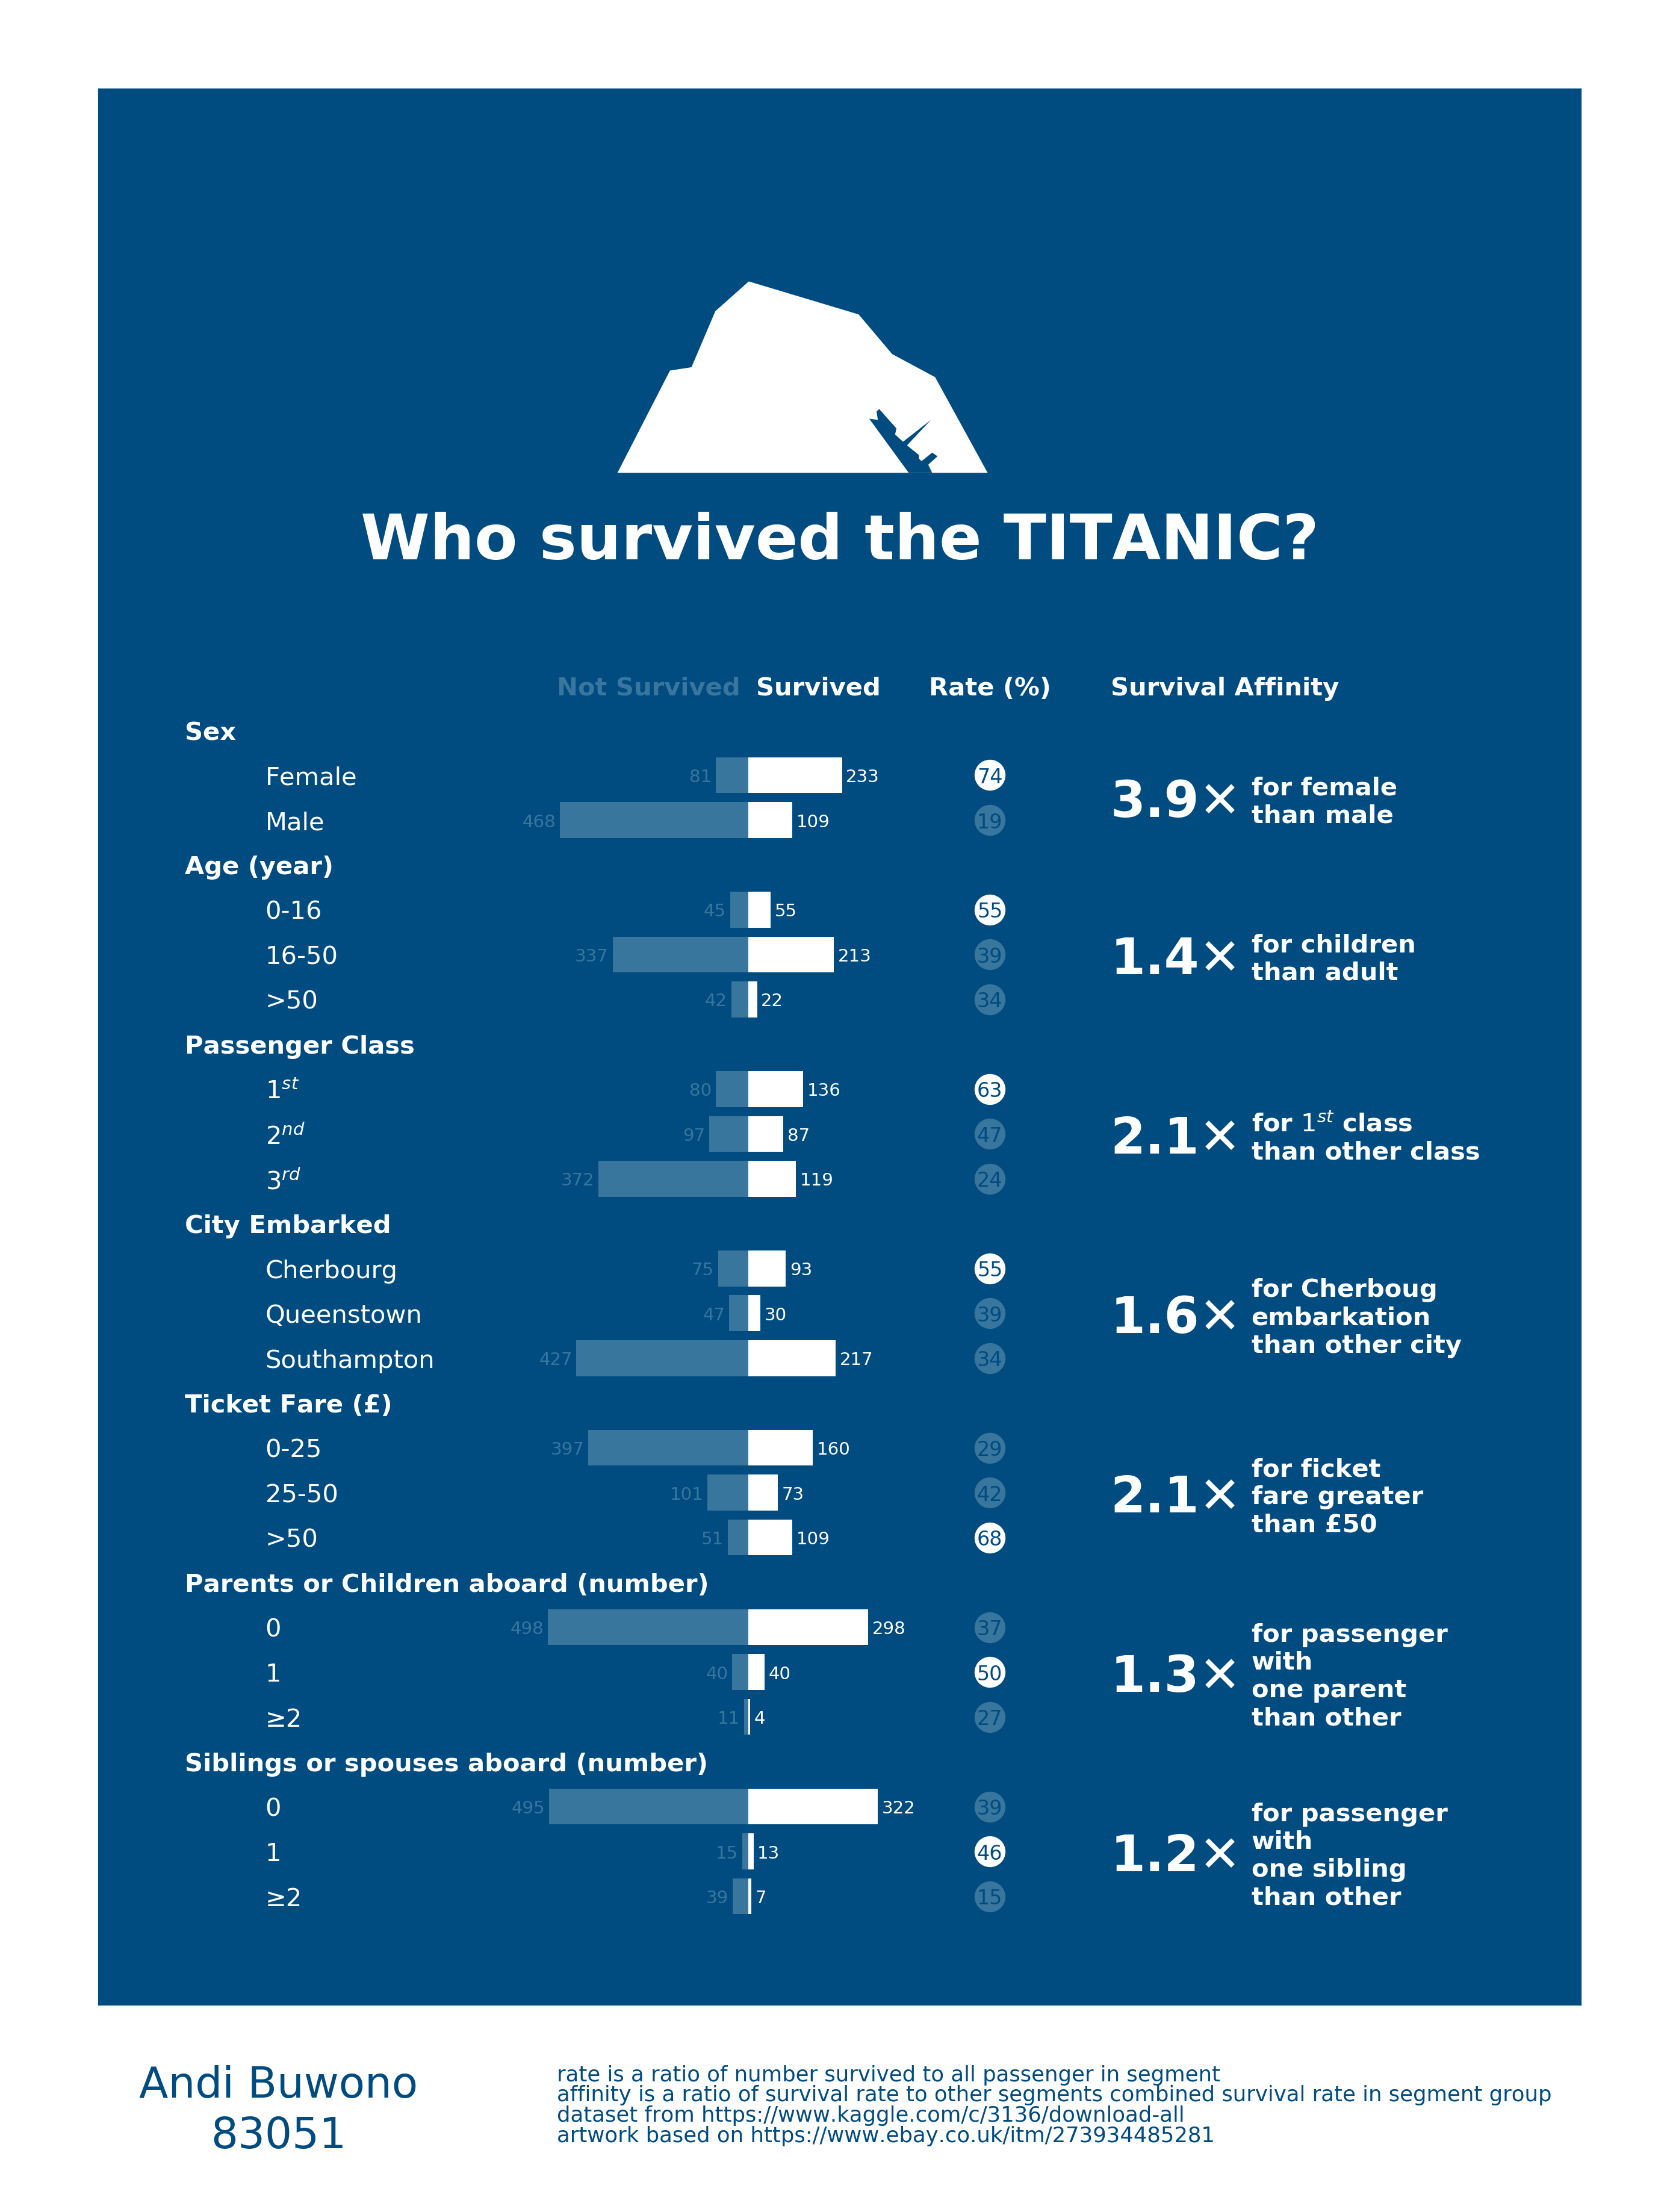

In [14]:
# add titanic visualization to panel
ax.figure=fig_vis
fig_vis.axes.append(ax)
fig_vis.add_axes(ax)

ax.set_position([cv.width(0.8), cv.height(1.5), cv.width(fig_width-1.2),
                    cv.height(fig_height-4.8)])

# preview
fig_vis

In [15]:
# print to file
fig_vis.savefig('fig/titanic_visualization.png', dpi=300)